In [1]:
# from jax import config
# config.update("jax_enable_x64", True)

import numpy as np
# import jax
# import jax.numpy as jnp
import healpy as hp
import ducc0
# import plotting_functions


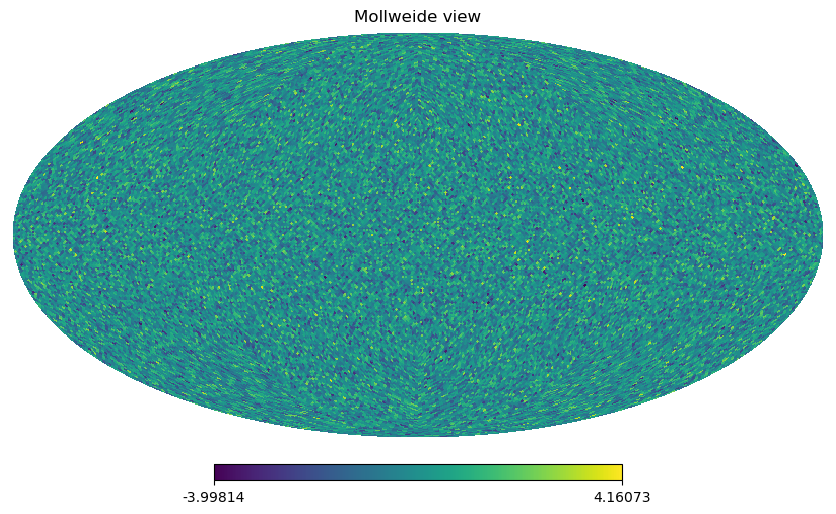

In [2]:
nside = 64
npix = 12*nside**2
lmax = 2*nside

map_in = np.random.normal(size=(npix,))
hp.mollview(map_in)

In [3]:
%%time
flm_HP = hp.map2alm(map_in, lmax=lmax, iter=0)

CPU times: user 1.86 ms, sys: 1.07 ms, total: 2.93 ms
Wall time: 1.25 ms


In [4]:
ducc0.healpix.Healpix_Base.sht_info

<instancemethod sht_info at 0x14e7ef190>

In [5]:
np.expand_dims(map_in,axis=0).shape

(1, 49152)

In [6]:
%%time

flm_ducc = ducc0.sht.adjoint_synthesis_2d(map=np.expand_dims(map_in,axis=0), lmax=lmax, spin=0, nthreads=0)

TypeError: adjoint_synthesis_2d(): incompatible function arguments. The following argument types are supported:
    1. (*, map: numpy.ndarray, spin: int, lmax: int, geometry: str, mmax: object = None, nthreads: int = 1, alm: object = None, mode: str = 'STANDARD', phi0: float = 0.0, mstart: object = None, lstride: int = 1) -> numpy.ndarray

Invoked with: kwargs: map=array([[-1.02363273,  0.19603222, -0.28641119, ..., -0.29621904,
        -1.37429465,  2.29695011]]), lmax=128, spin=0, nthreads=0

In [7]:
def nalm(lmax, mmax):
    return ((mmax+1)*(mmax+2))//2 + (mmax+1)*(lmax-mmax)

def random_alm(lmax, mmax, spin, ncomp, rng):
    res = rng.uniform(-1., 1., (ncomp, nalm(lmax, mmax))) \
     + 1j*rng.uniform(-1., 1., (ncomp, nalm(lmax, mmax)))
    # make a_lm with m==0 real-valued
    res[:, 0:lmax+1].imag = 0.
    ofs=0
    for s in range(spin):
        res[:, ofs:ofs+spin-s] = 0.
        ofs += lmax+1-s
    return res

rng = np.random.default_rng(np.random.SeedSequence(42))
alm = random_alm(lmax, mmax=lmax, spin=0, ncomp=1, rng=rng)

In [8]:
dict_healpy = ducc0.healpix.Healpix_Base(nside=nside, scheme='RING').sht_info()
print(dict_healpy.keys())

dict_keys(['theta', 'phi0', 'nphi', 'ringstart'])


In [13]:
geometry = "healpixT"
nphi=dict_healpy['nphi']
nthreads = 0
nrings = 4*nside-1

In [14]:
map_ = ducc0.sht.synthesis_2d(alm=alm, lmax=lmax, mmax=lmax, spin=0, ntheta=nrings, nphi=nphi, nthreads=nthreads, geometry=geometry)

In [48]:
map_.shape

(1, 257, 258)

In [49]:
257*258

66306

In [18]:
%%time
flm_check = s2fft.forward_jax(
    map_in,
    lmax+1,
    spin=0,
    nside=nside,
    sampling=sampling,
    reality=True,
    precomps=precomps,
    spmd=False,
    )

CPU times: user 54.4 s, sys: 1.34 s, total: 55.8 s
Wall time: 46.4 s


In [19]:
%%time
flm_check = s2fft.forward_jax(
    map_in,
    lmax+1,
    spin=0,
    nside=nside,
    sampling=sampling,
    reality=True,
    precomps=precomps,
    spmd=False,
    )

CPU times: user 26.8 s, sys: 367 ms, total: 27.1 s
Wall time: 17.6 s


In [20]:
%%time
flm_check = s2fft.forward_jax(
    map_in,
    lmax+1,
    spin=0,
    nside=nside,
    sampling=sampling,
    reality=True,
    precomps=precomps,
    spmd=False,
    )

CPU times: user 26.7 s, sys: 377 ms, total: 27.1 s
Wall time: 17.8 s


In [21]:
%%time
map_output_HP = hp.alm2map(flm_HP, lmax=lmax, nside=nside)

CPU times: user 167 ms, sys: 13.4 ms, total: 180 ms
Wall time: 41.3 ms


In [22]:
%%time
precomps_inverse = s2fft.generate_precomputes(lmax+1, 0, sampling, nside, False)

CPU times: user 18.2 s, sys: 22.4 s, total: 40.6 s
Wall time: 2min 33s


In [23]:
%%time
map_output_S2FFT = s2fft.inverse(
        flm_check,
        lmax+1,
        spin=0,
        nside=nside,
        sampling=sampling,
        method="jax",
        reality=True,
        precomps=precomps_inverse,
        spmd=False,
    )

2024-02-29 10:22:49.318037: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_inverse_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-02-29 10:26:12.706417: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m23.389885s

********************************
[Compiling module jit_inverse_jax] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


CPU times: user 5min 43s, sys: 16.1 s, total: 6min
Wall time: 5min 59s


In [24]:
%%time
map_output_S2FFT = s2fft.inverse(
        flm_check,
        lmax+1,
        spin=0,
        nside=nside,
        sampling=sampling,
        method="jax",
        reality=True,
        precomps=precomps_inverse,
        spmd=False,
    )

CPU times: user 27 s, sys: 433 ms, total: 27.5 s
Wall time: 19 s


In [25]:
%%time
map_output_S2FFT = s2fft.inverse(
        flm_check,
        lmax+1,
        spin=0,
        nside=nside,
        sampling=sampling,
        method="jax",
        reality=True,
        precomps=precomps_inverse,
        spmd=False,
    )

CPU times: user 26.6 s, sys: 377 ms, total: 27 s
Wall time: 17.9 s


In [26]:
diff = jnp.abs(map_output_S2FFT-map_in)

print(jnp.max(diff), jnp.mean(diff), jnp.std(diff))

4.257247204085525 0.6508862980435486 0.49145927892759467
